 This notebook trains a Siamese network to discriminate deep fake images from original images

 Subsections

*   Loading the dataset
*   Preprocessing the data
*   Data Visualization
*   Compile Siamese Network
*   Train the Network
*   Test the Network







# Load the dataset

In [3]:
# Mount Google Drive
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from matplotlib import path
import os
import random
from pathlib import Path as path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import resnet, vgg16
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import applications 

In [5]:
# Set constants and hyper parameters
# Change the embedding model here
embedding = "vgg"

target_shape = (224, 224) if embedding == "vgg" else (200, 200)

cache_dir = path(path.home()) / ".siamese_images"
anchor_images_path = cache_dir / "real_imgs"
negative_images_path = cache_dir / "fake_imgs"

In [6]:
# Download dataset from Google Drive
!gdown --id 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
!gdown --id 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
!unzip -oq /content/drive/MyDrive/datamining/large/real_imgs.zip -d $cache_dir
!unzip -oq /content/drive/MyDrive/datamining/large/fake_imgs.zip -d $cache_dir

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
To: /content/left.zip
100% 104M/104M [00:00<00:00, 139MB/s] 
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
To: /content/right.zip
100% 104M/104M [00:00<00:00, 228MB/s] 


# Data Preprocessing

In [7]:
def load_preprocess_image(file_name:str):
  """
  Load image from the file (JPEG), preprocess and resize to target shape
  """
  image = tf.io.read_file(file_name) 
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  return tf.image.resize(image, target_shape)


def preprocess_triplets(
    anchor_image:str, 
    positive_image:str,
     negative_image:str
     ):
  """
  Load and preprocess anchor, positive and negative iamges
  """
  return (
      load_preprocess_image(anchor_image),
      load_preprocess_image(positive_image),
      load_preprocess_image(negative_image)
  )

In [8]:
# Collect all images filenames
anchor_images = [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
negative_images = [str(negative_images_path / f) for f in os.listdir(negative_images_path)]
positive_images = [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
np.random.RandomState(seed=32).shuffle(positive_images)

# Create Datasets
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

# Preprocess pipeline
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=256)
dataset = dataset.map(preprocess_triplets)

image_count = len(anchor_images)
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)



Visualize some images

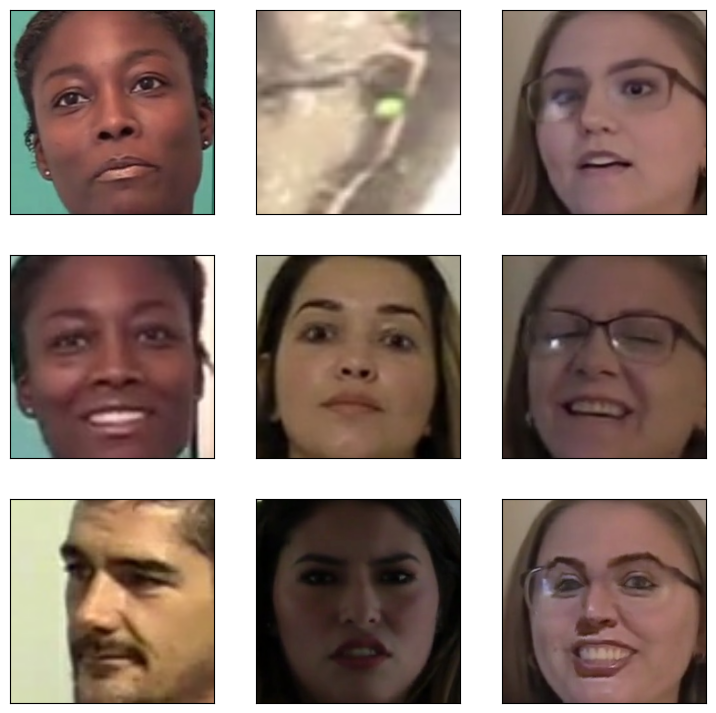

In [9]:
def visualize(anchor, positive, negative):

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

# Building the Model
## Encoding Features
We are experimenting with two models


*   Resnet
*   Vgg16







In [10]:


def get_embedding_model(model_name:str):
  # vgg16
  if model_name == "vgg":
    target_shape = (224, 224)
    vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = target_shape + (3,))
    for layer in vgg_conv.layers[:-2]:
      layer.trainable = False
    flatten = layers.Flatten()(vgg_conv.output)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    dense2 = layers.Dense(256, activation="sigmoid")(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(128)(dense2)
  # res50
  if model_name == "res50":
    base_cnn = resnet.ResNet50(
        weights = "imagenet", input_shape=target_shape + (3,), include_top=False
    )
    flatten = layers.Flatten()(base_cnn.layers[-1].output)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(128)(dense2)

  #Xception

  embedding = Model(vgg_conv.input, output, name="Embedding")
  return embedding




In [11]:
class DistanceLayer(layers.Layer):
    """
    
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))



embedding_model = get_embedding_model(embedding)


if embedding == "vgg":
  distances = DistanceLayer()(
      embedding_model(vgg16.preprocess_input(anchor_input)),
      embedding_model(vgg16.preprocess_input(positive_input)),
      embedding_model(vgg16.preprocess_input(negative_input)),
  )
else:
  distances = DistanceLayer()(
      embedding_model(resnet.preprocess_input(anchor_input)),
      embedding_model(resnet.preprocess_input(positive_input)),
      embedding_model(resnet.preprocess_input(negative_input)),
  )

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)



In [12]:
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                            

In [13]:
class SiameseModel(Model):
    """
    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients 
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss 
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):

        return [self.loss_tracker]


In [15]:
optimizer = optimizers.Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizer)
# siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

In [16]:
def test_on_triplets():
  pos_scores, neg_scores = [], []

  for batch in train_dataset:
      prediction = siamese_model.predict(batch)
      pos_scores += list(prediction[0])
      neg_scores += list(prediction[1])
  
  accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
  ap_mean = np.mean(pos_scores)
  an_mean = np.mean(neg_scores)
  ap_stds = np.std(pos_scores)
  an_stds = np.std(neg_scores)
  
  print(f"Accuracy on test = {accuracy:.5f}")
  return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [ ]:
import time
save_all = False
epochs = 10

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in train_dataset:
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets()
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 763 sec)
Loss on train    = 0.49987
1/1 [==============================] - 54s 54s/step
